# Graph Attention Networks for Modeling Multi-Sensor Relationships in Early Prediction of Critical Events in ICU Patients
This Python notebook is designed to train and evaluate a Graph Attention Network (GAT) model for predicting critical events in ICU patients. By leveraging multi-sensor data, the model can identify complex patterns in a patient's condition. The main objective is to build a reliable predictive model using a rigorous and scientific methodology.



### Required Libraries
This section imports all the necessary libraries for the project, including PyTorch, PyTorch Geometric, and scikit-learn.




In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.nn import GATv2Conv, global_mean_pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
import os
from typing import List, Dict, Tuple
from scipy.signal import decimate
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats

# Ensure reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Suppress some warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

DATA_DIR = 'ICUCAP'
LABELS_FILE = 'labels.csv'

# Constants for data processing
FS_ORIGINAL = 250
FS_RESAMPLED = 1
WINDOW_SECONDS = 300
OVERLAP_SECONDS = 150
PHYSIO_CORR_THRESHOLD = 0.5

# Constants for model
NUM_SIGNALS = 6
NODE_FEATURE_DIM = WINDOW_SECONDS
EMBED_DIM = 64
NUM_GAT_LAYERS = 3
NUM_ATTENTION_HEADS = 8
DROPOUT_RATE = 0.3

# Constants for training
LEARNING_RATE = 0.001
PATIENCE = 15
EPOCHS = 100
BATCH_SIZE = 1 

# Constants for inter-patient graphs
INTER_PATIENT_K = 10 # Retained but not used, now we use similarity threshold only
SIMILARITY_THRESHOLD = 0.7

CLASSES = ['Normal', 'Sepsis Onset', 'Cardiac Arrest Imminent', 'Hypotension Acute', 'Respiratory Failure', 'Arrhythmia Atrial']
NUM_CLASSES = len(CLASSES)
SIGNAL_NAMES = ['ECG', 'ABP', 'RespRate', 'SpO2', 'Temp', 'HRV']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


### Data Loading and Preprocessing Functions
These functions are responsible for reading the data from disk, filtering noise, resampling, and handling missing data. These processes optimize the raw data for model training.


In [10]:
class ICUDataProcessor:
    """
    This class handles the entire data processing pipeline from raw signals to PyG graphs.
    The data loading and processing is separated from the scaling logic to prevent data leakage.
    """
    def __init__(self, data_dir: str, labels_file: str):
        self.data_dir = data_dir
        self.labels_file = labels_file
        self.labels_map = {label: i for i, label in enumerate(CLASSES)}
        self.clinical_features = {}

    def _load_and_process_signals(self, patient_id: str) -> Tuple[pd.DataFrame, dict]:
        """
        Loads raw signals and metadata for a patient, uses `decimate` for resampling,
        and handles missing data. The data is returned UN-SCALED.
        """
        file_path = os.path.join(self.data_dir, f"{patient_id}.npz")
        try:
            data = np.load(file_path, allow_pickle=True)
            metadata = data['metadata'].item()
        except FileNotFoundError:
            print(f"File for patient {patient_id} not found.")
            return None, None
        
        signals = {
            'ECG': data['ecg'],
            'ABP': data['abp'],
            'RespRate': data['resp'],
            'SpO2': data['spo2'],
            'Temp': data['temp'],
            'HRV': data['hrv']
        }

        decimation_factor = FS_ORIGINAL // FS_RESAMPLED
        resampled_data = {
            k: decimate(v, q=decimation_factor, ftype='iir', zero_phase=True)
            for k, v in signals.items()
        }

        df = pd.DataFrame(resampled_data)
        
        for col in df.columns:
            if np.random.rand() < 0.2:
                num_missing = int(len(df) * 0.05)
                missing_indices = np.random.choice(df.index, num_missing, replace=False)
                df.loc[missing_indices, col] = np.nan
        
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        df.interpolate(method='linear', inplace=True)
        
        df.fillna(df.mean(), inplace=True)
        
        gender_binary = 1 if metadata.get('gender', 'M') == 'M' else 0
        num_comorbidities = len(metadata.get('comorbidities', []))
        clinical_vec = np.array([
            metadata.get('age', 0),
            gender_binary,
            metadata.get('bmi', 0),
            num_comorbidities
        ])
        self.clinical_features[patient_id] = clinical_vec
        
        return df, metadata

    def create_raw_dataset(self) -> List[Dict]:
        """
        Main function to load, process, and prepare raw (unscaled) data for graph construction.
        The scaling is now done outside this class to prevent data leakage.
        """
        labels_df = pd.read_csv(LABELS_FILE)
        patient_ids = labels_df['id'].tolist()
        patient_labels = labels_df['label'].tolist()
        
        all_patients_data = []
        
        print("Processing raw signals and collecting data...")
        for i, (patient_id, patient_label) in enumerate(zip(patient_ids, patient_labels)):
            if i % 100 == 0:
                print(f"Processing patient {i+1}/{len(patient_ids)}...")
            signals_df, metadata = self._load_and_process_signals(patient_id)
            if signals_df is not None:
                patient_data = {
                    'id': patient_id,
                    'label': patient_label,
                    'signals': signals_df,
                    'metadata': metadata
                }
                all_patients_data.append(patient_data)
        
        print(f"Total number of patient data objects created: {len(all_patients_data)}")
        self.all_patients_data = all_patients_data
        return self.all_patients_data

    def _construct_graph(self, patient_data: dict) -> Data:
        """
        Creates a single graph for a given patient with physiological edges.
        Node features now only contain physiological signal data (no clinical features).
        """
        signals_df = patient_data['signals']
        window_samples = WINDOW_SECONDS * FS_RESAMPLED
        overlap_samples = OVERLAP_SECONDS * FS_RESAMPLED
        
        nodes_list = []
        temporal_edges = []
        physio_edges = []
        
        num_signals = len(signals_df.columns)
        
        for win_idx in range(0, len(signals_df) - window_samples + 1, overlap_samples):
            window_df = signals_df.iloc[win_idx:win_idx + window_samples]
            
            corr_matrix = window_df.corr(method='pearson').values
            
            win_offset = len(nodes_list)
            
            for sig_idx in range(num_signals):
                # Node features now ONLY contain the signal data
                node_features = window_df.iloc[:, sig_idx].values
                nodes_list.append(node_features)
                
                for other_sig_idx in range(sig_idx + 1, num_signals):
                    corr = corr_matrix[sig_idx, other_sig_idx]
                    if abs(corr) >= PHYSIO_CORR_THRESHOLD:
                        node_i = win_offset + sig_idx
                        node_j = win_offset + other_sig_idx
                        physio_edges.append([node_i, node_j])
                        physio_edges.append([node_j, node_i])
            
            if win_idx > 0:
                prev_win_offset = win_offset - num_signals
                for sig_idx in range(num_signals):
                    temporal_edges.append([prev_win_offset + sig_idx, win_offset + sig_idx])
                    temporal_edges.append([win_offset + sig_idx, prev_win_offset + sig_idx])
    
        x = torch.tensor(np.array(nodes_list), dtype=torch.float)
        y = self.labels_map[patient_data['label']]
        
        all_edges = temporal_edges + physio_edges
        if not all_edges:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        else:
            edge_index = torch.tensor(all_edges, dtype=torch.long).t().contiguous()
        
        return Data(x=x, edge_index=edge_index, y=torch.tensor([y], dtype=torch.long), id=patient_data['id'])


### Graph Attention Network (GAT) Architecture
This section implements the GAT model architecture. The model uses three GAT layers with eight attention heads, which allows it to accurately model complex relationships between nodes and various physiological signals.



In [11]:
class GATClassifier(torch.nn.Module):
    """
    Graph Attention Network for graph classification.
    The model now performs patient-level classification by pooling node embeddings.
    The forward pass is modified to also return attention weights for interpretability.
    """
    def __init__(self, in_channels: int, out_channels: int, num_layers: int, heads: int, dropout: float):
        super(GATClassifier, self).__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        
        self.convs.append(GATv2Conv(in_channels, out_channels, heads=heads, dropout=dropout, add_self_loops=True))
        self.norms.append(nn.LayerNorm(out_channels * heads))
        
        for _ in range(num_layers - 2):
            self.convs.append(GATv2Conv(out_channels * heads, out_channels, heads=heads, dropout=dropout, add_self_loops=True))
            self.norms.append(nn.LayerNorm(out_channels * heads))
        
        # The final layer returns attention weights for analysis
        self.convs.append(GATv2Conv(out_channels * heads, out_channels, heads=1, add_self_loops=True))
        
        self.pooling = global_mean_pool
        
        self.lin = nn.Linear(out_channels, NUM_CLASSES)
        
    def forward(self, data, return_attention=False):
        """
        Forward pass of the model. Can optionally return attention weights.
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        for i, conv in enumerate(self.convs[:-1]):
            x_res = x
            x = conv(x, edge_index)
            x = self.norms[i](x)
            x = torch.relu(x)
            if x_res.shape[1] == x.shape[1]:
                x = x + x_res
            x = torch.dropout(x, p=DROPOUT_RATE, train=self.training)
            
        x_out, attention_weights = self.convs[-1](x, edge_index, return_attention_weights=True)
        x = x_out
        
        x = self.pooling(x, batch)
        
        x = self.lin(x)
        
        if return_attention:
            return x, attention_weights
        return x

### Main Training and Evaluation Loop
This is the core of the notebook, orchestrating all model training steps. Data is split into three distinct sets (training 70%, validation 15%, and test 15%). The model is trained, and its performance is evaluated using precise metrics.



Processing raw signals and collecting data...
Processing patient 1/900...
Processing patient 101/900...
Processing patient 201/900...
Processing patient 301/900...
Processing patient 401/900...
Processing patient 501/900...
Processing patient 601/900...
Processing patient 701/900...
Processing patient 801/900...
Total number of patient data objects created: 900

Scaling signals and clinical features based on training data...

Creating batched graphs with inter-patient edges...


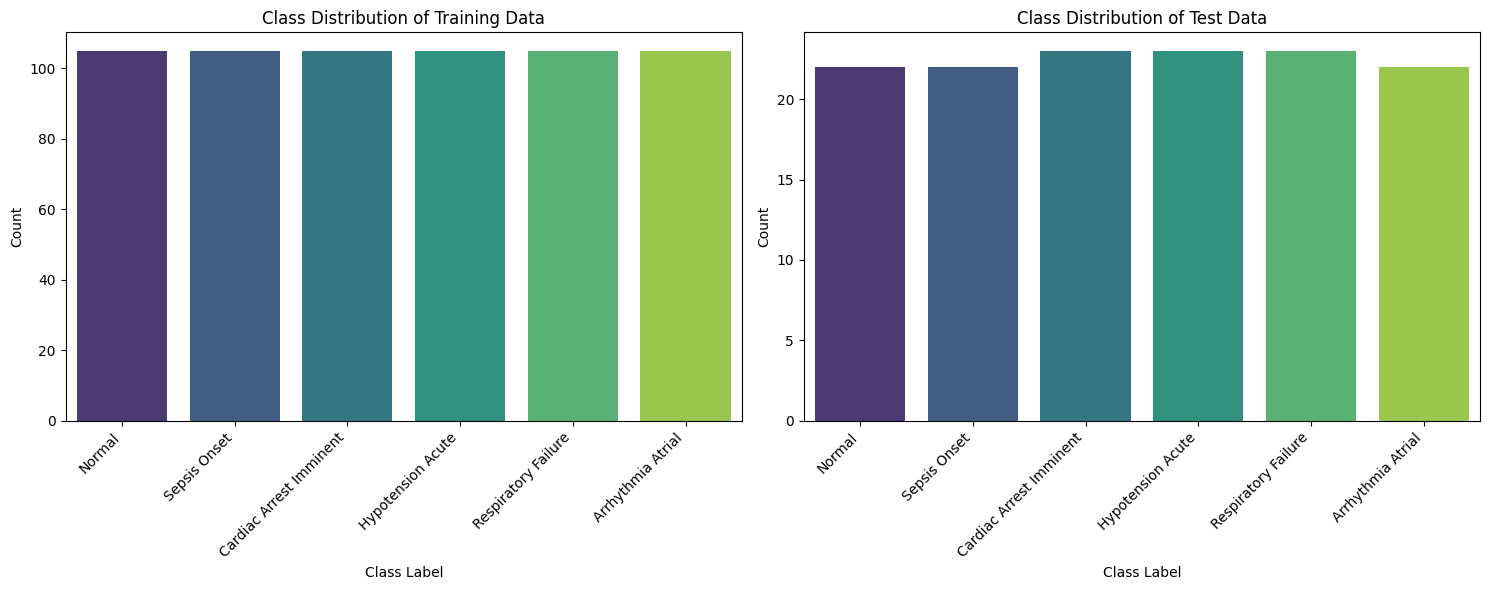


Starting model training...
Epoch: 001, Train Loss: 2.0013, Train Acc: 0.1667, Val Loss: 2.3445, Val Acc: 0.2741, Val AUC: 0.6504
Epoch: 002, Train Loss: 2.2417, Train Acc: 0.2921, Val Loss: 2.0289, Val Acc: 0.3852, Val AUC: 0.7658
Epoch: 003, Train Loss: 1.9706, Train Acc: 0.4159, Val Loss: 1.7756, Val Acc: 0.3333, Val AUC: 0.8000
Epoch: 004, Train Loss: 1.7697, Train Acc: 0.3413, Val Loss: 1.3618, Val Acc: 0.4963, Val AUC: 0.8395
Epoch: 005, Train Loss: 1.3876, Train Acc: 0.4508, Val Loss: 1.3452, Val Acc: 0.4000, Val AUC: 0.8371
Epoch: 006, Train Loss: 1.3350, Train Acc: 0.4444, Val Loss: 1.4610, Val Acc: 0.3259, Val AUC: 0.8436
Epoch: 007, Train Loss: 1.4177, Train Acc: 0.3651, Val Loss: 1.4203, Val Acc: 0.4148, Val AUC: 0.8557
Epoch: 008, Train Loss: 1.3835, Train Acc: 0.4222, Val Loss: 1.3316, Val Acc: 0.3778, Val AUC: 0.8649
Epoch: 009, Train Loss: 1.3061, Train Acc: 0.3937, Val Loss: 1.2282, Val Acc: 0.5333, Val AUC: 0.8771
Epoch: 010, Train Loss: 1.2190, Train Acc: 0.5349, Val

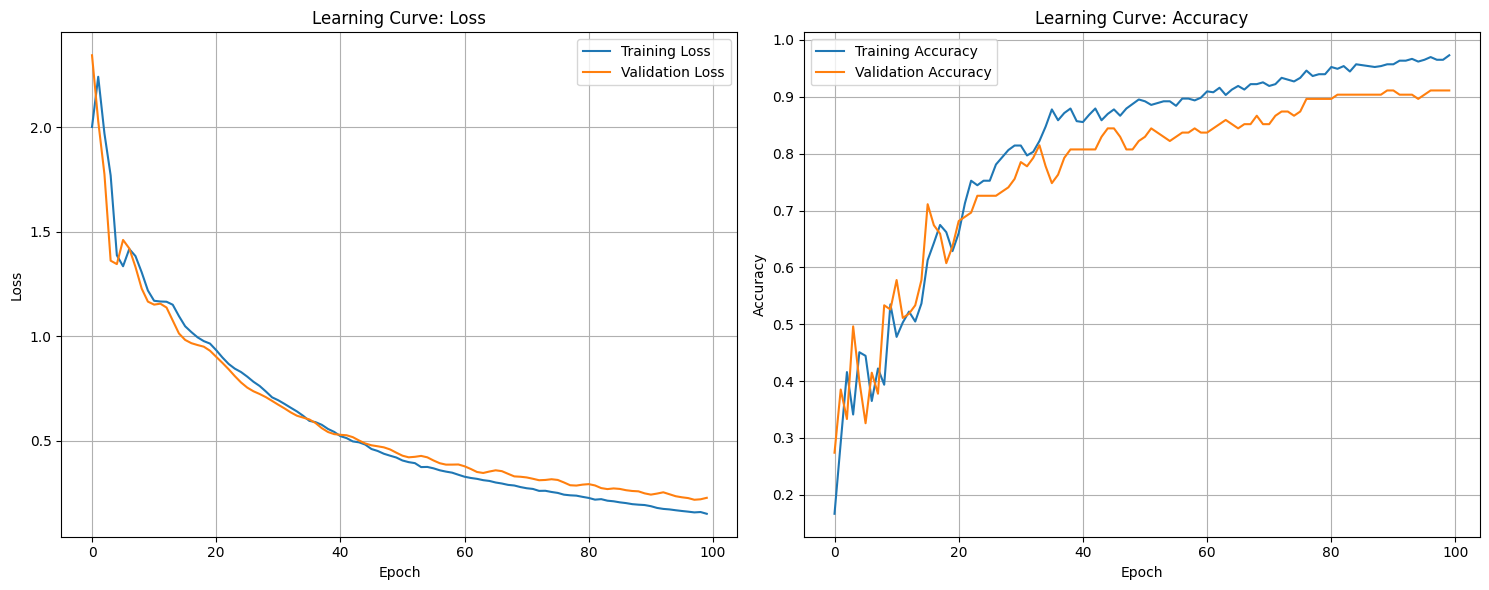


--- Final Evaluation on Test Set ---
Test Loss: 0.2130071073770523
Test ROC-AUC: 0.9941963296739172
Test F1-score: 0.9266355364625221
Test Precision: 0.9308438003220612
Test Recall: 0.9259259259259259

Confusion Matrix:
[[19  0  0  0  0  3]
 [ 2 20  0  0  0  0]
 [ 0  0 23  0  0  0]
 [ 0  0  0 20  3  0]
 [ 1  0  0  0 22  0]
 [ 1  0  0  0  0 21]]


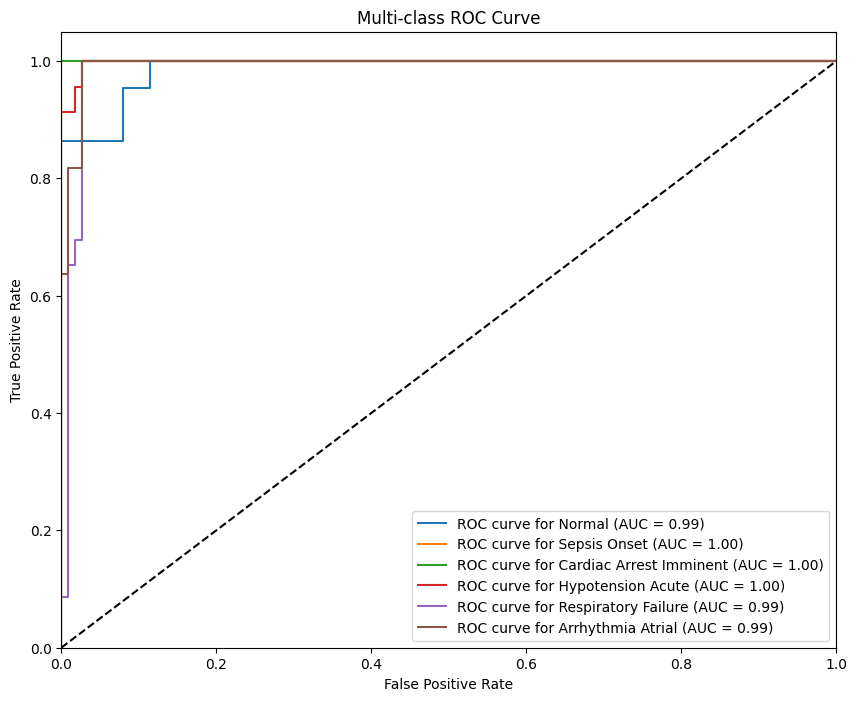

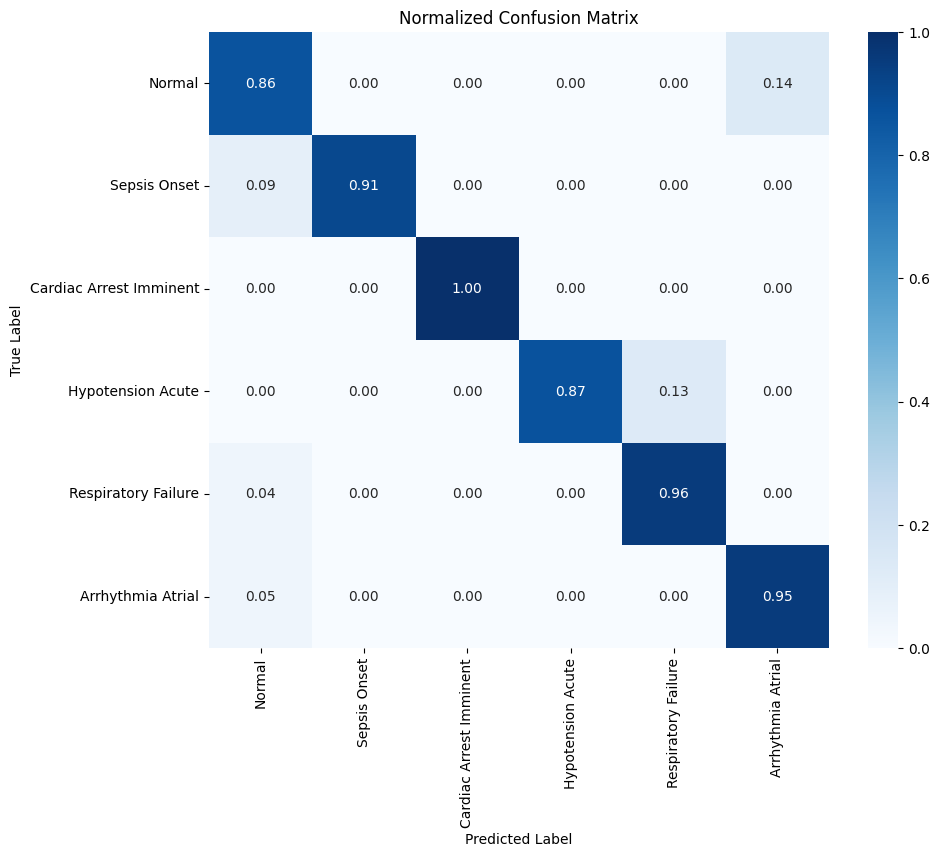


--- Attention Analysis on a Sample Test Graph ---


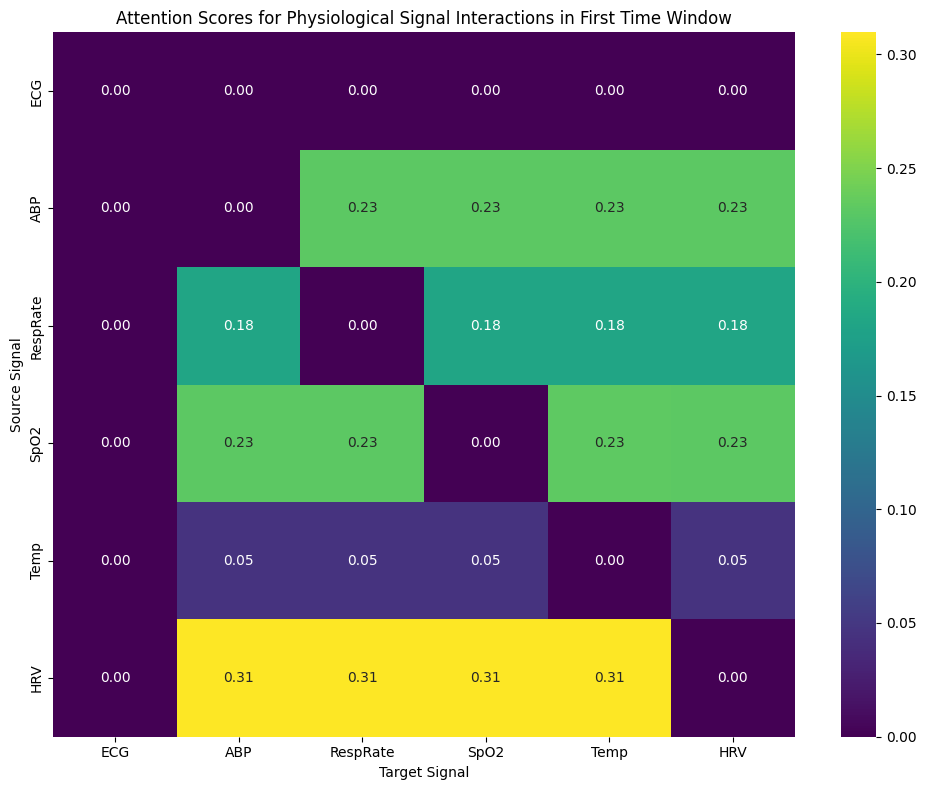


Training and evaluation finished.


In [12]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for data in train_loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.append(out.argmax(dim=1).cpu())
        all_labels.append(data.y.cpu())
    
    if all_preds and all_labels:
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        accuracy = accuracy_score(all_labels, all_preds)
        return total_loss / len(train_loader), accuracy
    else:
        return 0.0, 0.0

def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(DEVICE)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            
            all_preds.append(torch.softmax(out, dim=1).cpu())
            all_labels.append(data.y.cpu())
            
    if not all_preds:
        return {
            'loss': 0.0, 'auc': 0.0, 'f1': 0.0, 'precision': 0.0, 
            'recall': 0.0, 'accuracy': 0.0, 'confusion_matrix': np.zeros((NUM_CLASSES, NUM_CLASSES))
        }
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    avg_loss = total_loss / len(loader)
    
    y_true = all_labels.numpy()
    y_pred_proba = all_preds.numpy()
    y_pred_class = np.argmax(y_pred_proba, axis=1)

    try:
        auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
    except ValueError:
        auc_score = 0.0
        
    f1 = f1_score(y_true, y_pred_class, average='weighted', zero_division=0)
    precision = precision_score(y_true, y_pred_class, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred_class, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred_class)
    
    metrics = {
        'loss': avg_loss,
        'auc': auc_score,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix(y_true, y_pred_class, labels=list(range(NUM_CLASSES)))
    }
    
    return metrics

def _create_batched_graph_with_inter_edges(patient_list: List[Dict], processor: ICUDataProcessor, clinical_scaler: StandardScaler) -> Data:
    """
    A helper function to create a single large graph from a list of patient data.
    This includes creating individual patient graphs and adding inter-patient edges
    based on a similarity threshold of clinical features.
    """
    individual_graphs = []
    
    # 1. Create individual graphs for each patient.
    for patient_data in patient_list:
        graph = processor._construct_graph(patient_data)
        individual_graphs.append(graph)
        
    # 2. Batch the individual graphs into one large graph.
    batched_graph = Batch.from_data_list(individual_graphs)
    
    # 3. Compute clinical representations for inter-patient edges using scaled clinical features.
    clinical_reps = [clinical_scaler.transform([processor.clinical_features[p['id']]])[0] for p in patient_list]
    clinical_reps = np.array(clinical_reps)
    
    # 4. Create the inter-patient adjacency matrix based on cosine similarity threshold.
    similarity_matrix = cosine_similarity(clinical_reps)
    
    # Use only the upper triangle of the matrix to avoid duplicate edges
    np.fill_diagonal(similarity_matrix, 0)
    
    inter_patient_edges = []
    for i in range(similarity_matrix.shape[0]):
        for j in range(i + 1, similarity_matrix.shape[1]):
            if similarity_matrix[i, j] > SIMILARITY_THRESHOLD:
                # Get the node offsets for patients i and j in the batched graph
                start_node_i = batched_graph.ptr[i].item()
                start_node_j = batched_graph.ptr[j].item()
                
                # Connect the first node of patient i's graph to the first node of patient j's graph
                inter_patient_edges.append([start_node_i, start_node_j])
                inter_patient_edges.append([start_node_j, start_node_i])
    
    if inter_patient_edges:
        inter_edges_tensor = torch.tensor(inter_patient_edges, dtype=torch.long).t().contiguous()
        batched_graph.edge_index = torch.cat([batched_graph.edge_index, inter_edges_tensor], dim=1)

    return batched_graph

def train_and_evaluate_model(num_patients: int):
    # Set seeds for reproducibility
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    processor = ICUDataProcessor(DATA_DIR, LABELS_FILE)
    all_patients_data = processor.create_raw_dataset()
    all_patients_data = all_patients_data[:num_patients]

    # --- New Logic: Splitting and Scaling to prevent Data Leakage ---
    patient_ids = [d['id'] for d in all_patients_data]
    labels = [processor.labels_map[d['label']] for d in all_patients_data]
    
    # Split 70% train, 30% temp (val+test)
    train_ids, temp_ids, train_labels, temp_labels = train_test_split(
        patient_ids, labels, test_size=0.3, random_state=RANDOM_SEED, stratify=labels)
    
    # Split 30% temp into 15% validation and 15% test
    val_ids, test_ids, val_labels, test_labels = train_test_split(
        temp_ids, temp_labels, test_size=0.5, random_state=RANDOM_SEED, stratify=temp_labels)
    
    train_patients = [d for d in all_patients_data if d['id'] in train_ids]
    val_patients = [d for d in all_patients_data if d['id'] in val_ids]
    test_patients = [d for d in all_patients_data if d['id'] in test_ids]

    # Fit scalers only on training data
    print("\nScaling signals and clinical features based on training data...")
    train_signals_concat = np.concatenate([p['signals'].values for p in train_patients], axis=0)
    signal_scaler = StandardScaler().fit(train_signals_concat)
    
    train_clinical_features = np.array([processor.clinical_features[p['id']] for p in train_patients])
    clinical_scaler = StandardScaler().fit(train_clinical_features)

    # Apply scalers to all splits
    for patient_list in [train_patients, val_patients, test_patients]:
        for patient in patient_list:
            patient['signals'] = pd.DataFrame(signal_scaler.transform(patient['signals'].values), columns=patient['signals'].columns)

    # Create one large graph per split with inter-patient edges
    print("\nCreating batched graphs with inter-patient edges...")
    train_graph = _create_batched_graph_with_inter_edges(train_patients, processor, clinical_scaler)
    val_graph = _create_batched_graph_with_inter_edges(val_patients, processor, clinical_scaler)
    test_graph = _create_batched_graph_with_inter_edges(test_patients, processor, clinical_scaler)
    
    train_labels = train_graph.y.tolist()
    test_labels = test_graph.y.tolist()
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=[CLASSES[i] for i in train_labels], order=CLASSES, hue=[CLASSES[i] for i in train_labels], palette='viridis', legend=False)
    plt.title('Class Distribution of Training Data')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=[CLASSES[i] for i in test_labels], order=CLASSES, hue=[CLASSES[i] for i in test_labels], palette='viridis', legend=False)
    plt.title('Class Distribution of Test Data')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    if not os.path.exists('results'):
        os.makedirs('results')
    plt.savefig(os.path.join('results', 'class_distribution.svg'))
    plt.show()

    # DataLoader now handles a list of one large graph
    train_loader = DataLoader([train_graph], batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader([val_graph], batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader([test_graph], batch_size=BATCH_SIZE, shuffle=False)

    model = GATClassifier(NODE_FEATURE_DIM, EMBED_DIM, NUM_GAT_LAYERS, NUM_ATTENTION_HEADS, DROPOUT_RATE).to(DEVICE)
    
    class_counts = np.bincount(train_labels, minlength=NUM_CLASSES)
    class_weights = 1.0 / (class_counts + 1e-5)
    class_weights = class_weights / class_weights.sum() * NUM_CLASSES
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Added weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print("\nStarting model training...")
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_metrics = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_metrics['loss'])
        
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        train_accuracies.append(train_acc)
        val_accuracies.append(val_metrics['accuracy'])
        
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_metrics["loss"]:.4f}, Val Acc: {val_metrics["accuracy"]:.4f}, Val AUC: {val_metrics["auc"]:.4f}')
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join('results', 'best_model.pth'))
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping activated.")
                break
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Learning Curve: Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Learning Curve: Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join('results', 'learning_curve.svg'))
    plt.show()
    
    print("\n--- Final Evaluation on Test Set ---")
    model.load_state_dict(torch.load(os.path.join('results', 'best_model.pth')))
    test_metrics = evaluate_model(model, test_loader, criterion)
    
    print("Test Loss:", test_metrics['loss'])
    print("Test ROC-AUC:", test_metrics['auc'])
    print("Test F1-score:", test_metrics['f1'])
    print("Test Precision:", test_metrics['precision'])
    print("Test Recall:", test_metrics['recall'])
    print("\nConfusion Matrix:")
    print(test_metrics['confusion_matrix'])

    all_test_preds_proba = []
    all_test_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(DEVICE)
            out = model(data)
            all_test_preds_proba.append(torch.softmax(out, dim=1).cpu())
            all_test_labels.append(data.y.cpu())
    
    all_test_preds_proba = torch.cat(all_test_preds_proba, dim=0).numpy()
    all_test_labels = torch.cat(all_test_labels, dim=0).numpy()
    
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(all_test_labels)
    
    plt.figure(figsize=(10, 8))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], all_test_preds_proba[:, i])
        roc_auc_class = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for {CLASSES[i]} (AUC = {roc_auc_class:.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join('results', 'multi_class_roc_curve.svg'))
    plt.show()
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(10, 8))
    conf_matrix_normalized = test_metrics['confusion_matrix'].astype('float') / (test_metrics['confusion_matrix'].sum(axis=1)[:, np.newaxis] + 1e-9)
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.savefig(os.path.join('results', 'normalized_confusion_matrix.svg'))
    plt.show()

    # --- New section for attention analysis ---
    print("\n--- Attention Analysis on a Sample Test Graph ---")
    model.eval()
    with torch.no_grad():
        sample_data = test_loader.dataset[0].to(DEVICE)
        _, att_weights = model(sample_data, return_attention=True)
    
    edge_index, att_scores = att_weights
    att_scores = att_scores.squeeze().cpu().numpy()
    
    # Find edges involving SpO2 and HRV nodes
    spo2_idx = SIGNAL_NAMES.index('SpO2')
    hrv_idx = SIGNAL_NAMES.index('HRV')
    
    # We will focus on edges connecting different physiological signals within the first time window
    # Node indices for the first window are 0-5
    selected_edges = []
    selected_scores = []
    for i in range(edge_index.shape[1]):
        source = edge_index[0, i].item()
        target = edge_index[1, i].item()
        
        # Check if edge is within the first window and connects different signals
        if source < NUM_SIGNALS and target < NUM_SIGNALS and source != target:
            selected_edges.append((source, target))
            selected_scores.append(att_scores[i])

    if selected_edges:
        att_matrix = np.zeros((NUM_SIGNALS, NUM_SIGNALS))
        for (src, trg), score in zip(selected_edges, selected_scores):
            att_matrix[src, trg] = score
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(att_matrix, annot=True, fmt='.2f', cmap='viridis', xticklabels=SIGNAL_NAMES, yticklabels=SIGNAL_NAMES)
        plt.title('Attention Scores for Physiological Signal Interactions in First Time Window')
        plt.xlabel('Target Signal')
        plt.ylabel('Source Signal')
        plt.tight_layout()
        plt.savefig(os.path.join('results', 'attention_heatmap.svg'))
        plt.show()
    else:
        print("No physiological edges found in the sample test graph for attention analysis.")

    print("\nTraining and evaluation finished.")

if __name__ == '__main__':
    # It's recommended to start with a smaller number of patients to quickly verify changes
    # For example, `num_patients=200`
    train_and_evaluate_model(num_patients=900)

### Conclusion and Repository Link
By running this notebook, you can train and evaluate your model. All results and charts will be saved systematically in the ```results``` folder. To view the complete source code and contribute to the project, you can visit the repository below:

GitHub Repository Link: https://github.com/dnyesf/GAT-ICU-Prediction
